<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/ImageNet_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 259 (delta 45), reused 16 (delta 8), pack-reused 183
Receiving objects: 100% (259/259), 217.65 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Checking out files: 100% (30/30), done.
/content/TFG


In [0]:
%tensorflow_version 1.x

In [0]:
from utils import *
from adversarial_attacks import *
import torchvision.models as models
import json
from PIL import Image
import requests

In [37]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [0]:
class_idx = json.load(open("imagenet_class_index.json"))

In [0]:
mean_cifar10, std_cifar10 = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
mean_ImageNet, std_ImageNet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

def denormalize(img, dataset='cifar10'):  # img of size (3,H,W)
  mean = mean_cifar10 if dataset=='cifar10' else mean_ImageNet
  std = std_cifar10 if dataset=='cifar10' else std_ImageNet
  for channel in range(3):
    img[channel] = img[channel] * std[channel] + mean[channel]

  return img

def displayable(img, dataset='cifar10'):  # tensor of size 1xCxHxW
  return np.transpose(denormalize(img.squeeze().numpy(), dataset=dataset), (1,2,0))

In [463]:
#model = models.resnet50(pretrained=True)
#model = models.densenet169(pretrained=True)
#model = models.mobilenet_v2(pretrained=True)
model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [0]:
def image_loader(url):
  """load image, returns CUDA tensor"""
  transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  img = Image.open(requests.get(url, stream=True).raw)

  return transform(img)

In [0]:
img = torch.unsqueeze(image_loader('https://images.freeimages.com/images/large-previews/3f2/london-underground-sign-1444974.jpg'), dim=0)

In [490]:
model.eval()
img.requires_grad = True

output = model(img)
pred = output.max(1, keepdim=True)[1]
print('Input image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Input image classified as street_sign with a 100.00% confidence


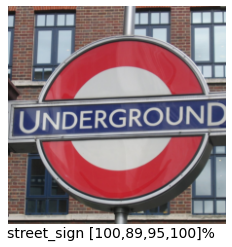

In [491]:
f = plt.figure()
plt.axis('off')
f.text(.50, .08, class_idx[str(pred.item())][1] + ' [100,89,95,100]%', ha='center', fontsize=14)
plt.imshow(displayable(img.clone().detach(), dataset='imagenet'))

In [0]:
adv_x, pert_x = fgsm(model, img, pred[0], output, epsilon=0.12, clip=True)

In [488]:
output = model(adv_x)
pred = output.max(1, keepdim=True)[1]
print('Adversarial image classified as', class_idx[str(pred.item())][1], end='')
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(' with a {:.2f}% confidence'.format(percentage[pred].item()))

Adversarial image classified as buckle with a 15.34% confidence


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.08, 'buckle (15.34%)')

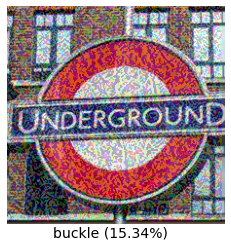

In [489]:
f = plt.figure()
plt.axis('off')
plt.imshow(displayable(adv_x.clone().detach(), dataset='imagenet'))
f.text(.50, .08, class_idx[str(pred.item())][1] + ' ({:.2f}%)'.format(percentage[pred].item()), ha='center', fontsize=14)
